# Deep Cancer Detection
### Applied Deep Learning 2019 - Final Project
#### By Muf Tayebaly (mt3195)

## Starter Code (Knowing the Data)

In [33]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 2s (53.6 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145655 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [0]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  48.6M      0  0:00:10  0:00:10 --:--:-- 52.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  27.2M      0 --:--:-- --:--:-- --:--:-- 27.3M


In [0]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

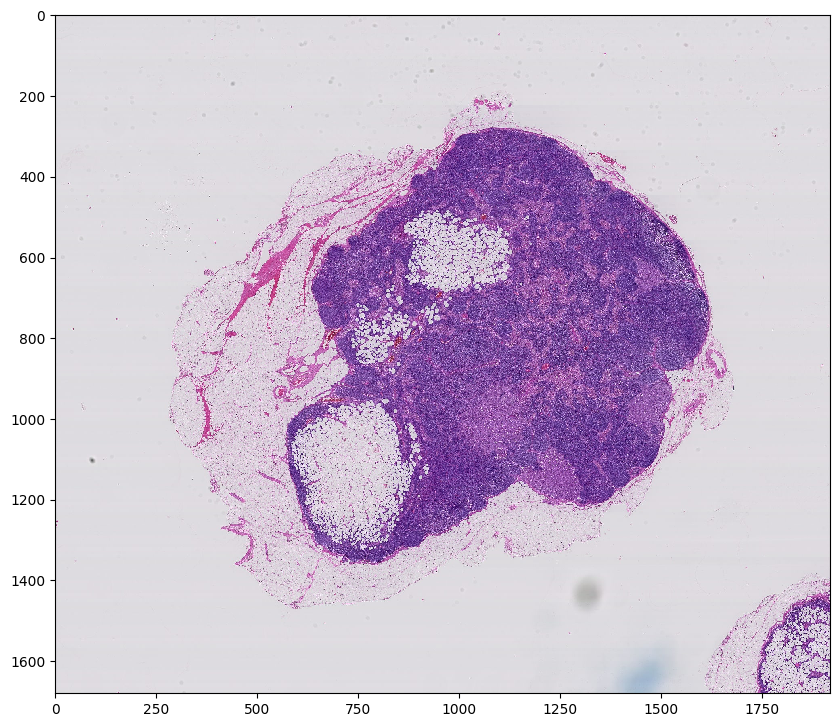

In [0]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

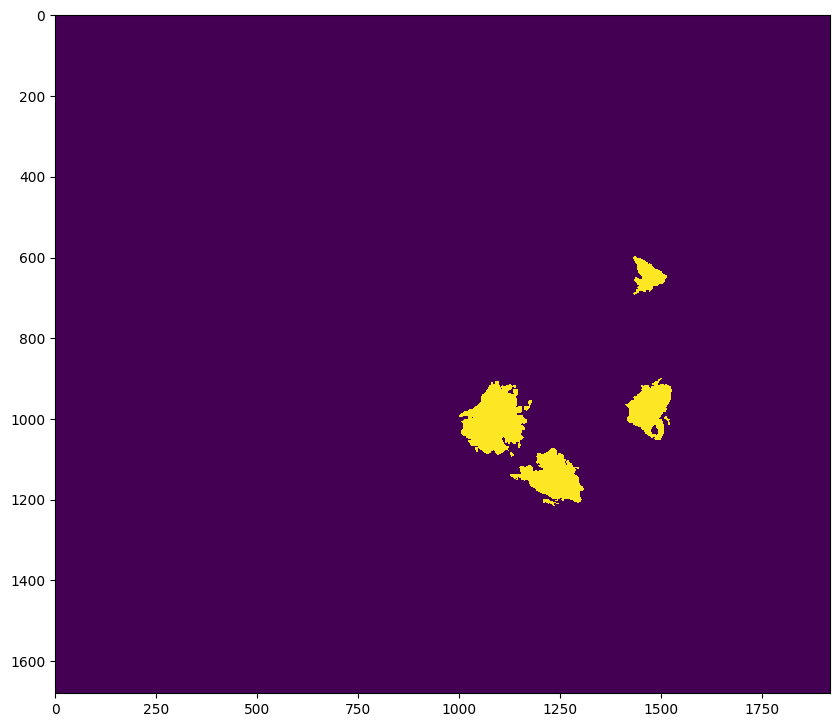

In [0]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

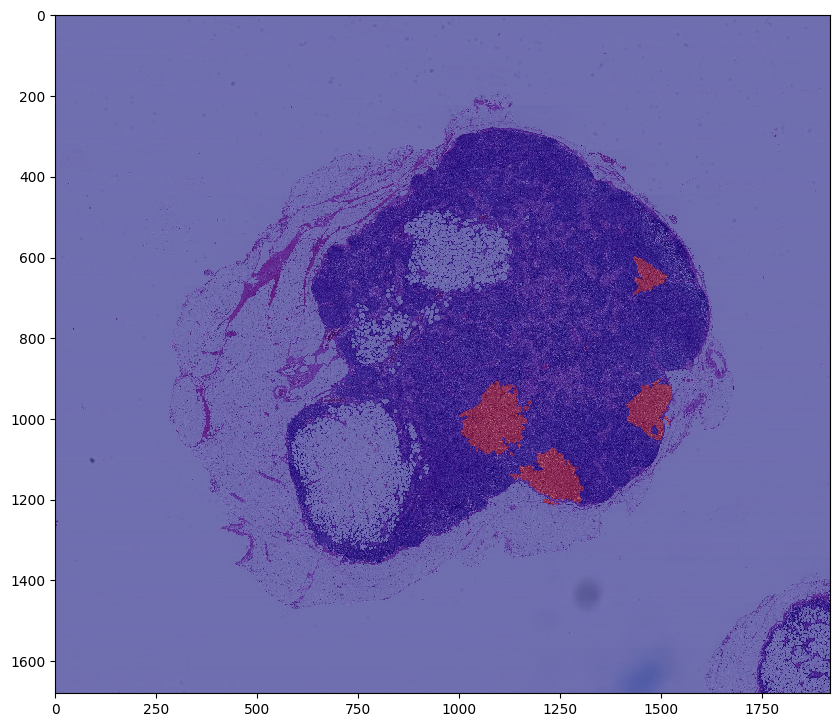

In [0]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0

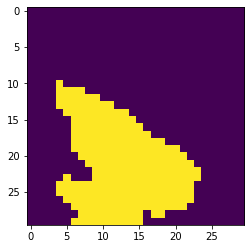

In [0]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=355 * 128, y=140 * 128, level=7, width=30, height=30)[:,:,0]
plt.imshow(region)
for i in range(1,30):
  print(region[i])

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

905504 tissue_pixels pixels (32.1 percent of the image)


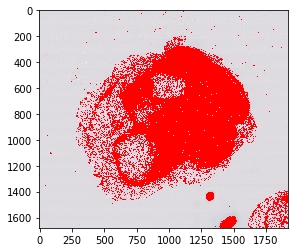

In [0]:
tissue_pixels = list(find_tissue_pixels(slide_image))
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [0]:
print(tissue_pixels[0:10])

[(0, 462), (0, 463), (0, 972), (0, 973), (0, 974), (0, 975), (0, 977), (0, 978), (0, 979), (0, 980)]


## Data Preprocessing

### Getting Dataset
Mounting google drive.  I copied the slides folder into my own drive to prevent exceeding download limits as mentioned in piazza.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = '/content/gdrive/My Drive/'
slide_dir = '/content/gdrive/My Drive/slides/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls '$slide_dir'

 tumor_001_mask.tif   tumor_031.xml	   tumor_081.tif
 tumor_001.tif	      tumor_035_mask.tif   tumor_081.xml
 tumor_001.xml	      tumor_035.tif	   tumor_084_mask.tif
 tumor_002_mask.tif   tumor_035.xml	   tumor_084.tif
 tumor_002.tif	     'tumor_038 (1).xml'   tumor_084.xml
 tumor_002.xml	      tumor_038.tif	   tumor_091_mask.tif
 tumor_005_mask.tif   tumor_038.xml	   tumor_091.tif
 tumor_005.tif	      tumor_057_mask.tif   tumor_091.xml
 tumor_005.xml	      tumor_057.tif	   tumor_094_mask.tif
 tumor_012_mask.tif   tumor_057.xml	   tumor_094.tif
 tumor_012.tif	      tumor_059_mask.tif   tumor_094.xml
 tumor_012.xml	      tumor_059.tif	   tumor_096_mask.tif
 tumor_016_mask.tif   tumor_059.xml	   tumor_096.tif
 tumor_016.tif	      tumor_064_mask.tif   tumor_096.xml
 tumor_016.xml	      tumor_064.tif	   tumor_099.xml
 tumor_019_mask.tif   tumor_064.xml	   tumor_101_mask.tif
 tumor_019.tif	      tumor_075_mask.tif   tumor_101.tif
 tumor_019.xml	      tumor_075.tif	   tumor_101.xml
 tumor_02


### Get Patches Only With 5% Tissue or More
Testing out the patch using tumor_091.tif

In [0]:
#create blank image
n = 1
blank_img = [[[255 for k in range(3)] for j in range(n)] for i in range(n)]

#function to get good patches only
def get_good_patches(slide, tumor_mask, slideId, 
                     slide_path="", slide_dir='/content/gdrive/My Drive/slides_new/', 
                     level=5, size=128, percent=5, plot=False, save=False):
  #set data
  data=[]
  #get factor
  factor = int(slide.level_downsamples[level])
  #print only if plot is on
  if plot:
    print("Slide %s Level %d, dimensions: %s downsample factor %d" % (slide_path, 
                                                                      level, 
                                                                      slide.level_dimensions[level], 
                                                                      factor))
  #get num of windows in width and height
  w_count = slide.level_dimensions[level][0]//size
  h_count = slide.level_dimensions[level][1]//size

  #print('wide:',w_count,'long:',h_count)

  #loop through height count then width count windows
  for h in range(h_count):
    if plot:
      row=plt.figure(figsize=(10,10), dpi=100)
    for w in range(w_count):
      region = read_slide(slide, 
                          x=w*size*factor, 
                          y=h*size*factor, 
                          level=level, 
                          width=size, 
                          height=size)
      tissue_pixels = list(find_tissue_pixels(region))
      percent_tissue = len(tissue_pixels) / float(region.shape[0] * region.shape[0]) * 100
      #print(w,h,percent_tissue)
      if plot:
        row.add_subplot(1, w_count, w+1)
        if percent_tissue>=percent:
          plt.imshow(region)
        else:
          plt.imshow(blank_img)
        plt.axis('off')

      isCancer=0
      cancerSum=0
      patch_path=''
      mask_path=''

      #do we use this patch?
      if percent_tissue>=percent:
        #has tumor?
        tumor_region = read_slide(tumor_mask, 
                          x=w*size*factor, 
                          y=h*size*factor, 
                          level=level, 
                          width=size, 
                          height=size)[:,:,0]
        tumorData=np.array(tumor_region)
        cancerSum=np.sum(tumorData)
        if cancerSum > 0:
          isCancer=1

        #save the patch images for later use
        if isCancer==1:
          patch_path = slide_dir + 'cancer/' + str(slideId) + '_lvl_' + str(level) + '_x_' + str(w) + '_y_' + str(h) + '.jpg'
          mask_path = slide_dir + 'cancer/' + str(slideId) + '_lvl_' + str(level) + '_x_' + str(w) + '_y_' + str(h) + '_mask.jpg'
        else:
          patch_path = slide_dir + 'no_cancer/' + str(slideId) + '_lvl_' + str(level) + '_x_' + str(w) + '_y_' + str(h) + '.jpg'
          mask_path = slide_dir + 'no_cancer/' + str(slideId) + '_lvl_' + str(level) + '_x_' + str(w) + '_y_' + str(h) + '_mask.jpg'
        
        if save:
          if not os.path.exists(slide_dir):
            os.makedirs(slide_dir)
          if not os.path.exists(slide_dir + 'cancer/'):
            os.makedirs(slide_dir + 'cancer/')
          if not os.path.exists(slide_dir + 'no_cancer/'):
            os.makedirs(slide_dir + 'no_cancer/')
          if not os.path.exists(patch_path):
            plt.imsave(patch_path, region)
          #if not os.path.exists(mask_path):
            #plt.imsave(mask_path, tumor_region)
        
        #add data
        data.append({'slideId':slideId, 'patch_path':patch_path, 'level':level, 'size':size, 'patch_x':w, 'patch_y':h, 'cancer':isCancer})
      
  #return data
  return data

Slide tumor_091.tif Level 4, dimensions: (3840, 3360) downsample factor 16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


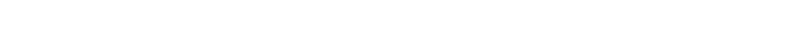

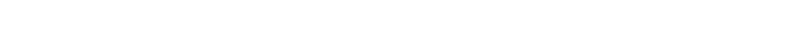

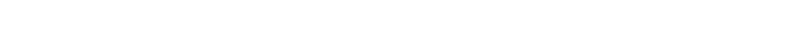

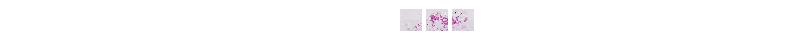

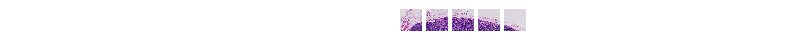

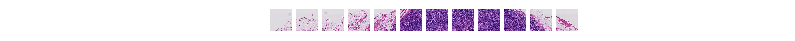

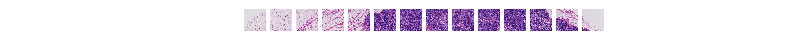

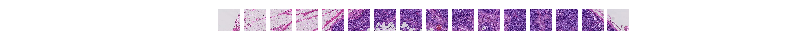

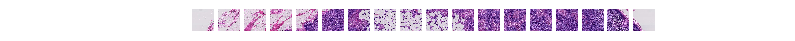

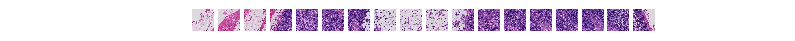

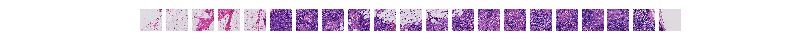

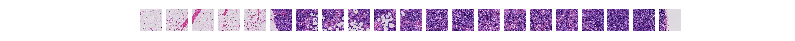

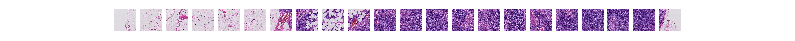

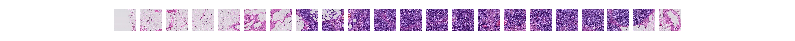

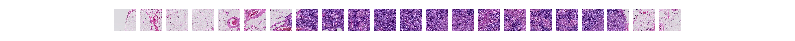

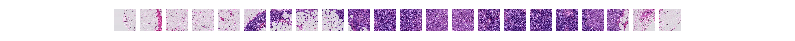

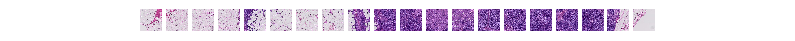

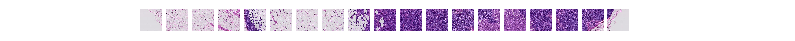

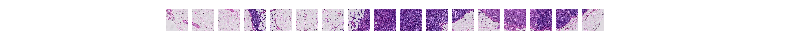

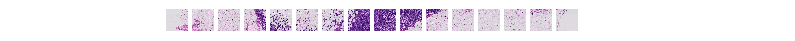

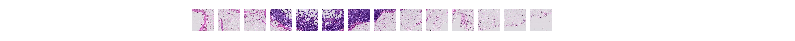

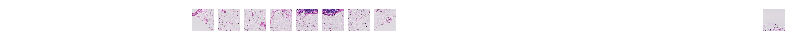

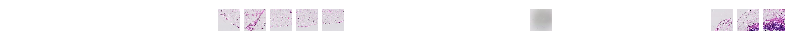

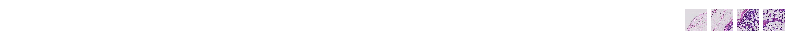

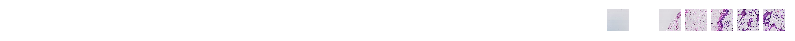

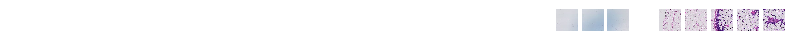

In [0]:
#test out the slide with 5% tissue
level=4
size=128 #128 by 128 grid

trial_data = get_good_patches(slide, tumor_mask, slideId='091', slide_path=slide_path, 
                              level=level, size=size, percent=5, plot=True)

As you can see, we are creating a lot of training efficiency by removing the grey areas.  Now lets look at the data we produce and confirm the tumor is binary classified correctly.

In [0]:
import pandas as pd

trial_df = pd.DataFrame(trial_data)
print('Number of patches:', len(trial_df))
trial_df.iloc[90:110]

Number of patches: 338


slideId                                         patch_path  ...  patch_y  cancer
90      091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       10       0
91      091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       10       0
92      091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       10       0
93      091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       10       0
94      091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       10       0
95      091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       10       0
96      091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       10       0
97      091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       10       0
98      091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       10       0
99      091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       10       0
100     091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       10       0
101     091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       10       0
102     091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       10       0
103     091  /content/gdrive/My Drive/slides_new/cancer/091...  ...       10       1
104     091  /content/gdrive/My Drive/slides_new/cancer/091...  ...       10       1
105     091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       10       0
106     091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       10       0
107     091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       11       0
108     091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       11       0
109     091  /content/gdrive/My Drive/slides_new/no_cancer/...  ...       11       0

[20 rows x 7 columns]

### Create Training Dataset on Level 4

In [0]:
#delete the data set if need to first
!rm -rf '/content/gdrive/My Drive/slides_lvl4/'

In [0]:
#create master data [slide_path, level, patch_x, patch_y, tumor]
master_patches = []
new_slide_dir='/content/gdrive/My Drive/slides_lvl4/'
lvl=4

#all slides
#note slide 099 did not have the images and 038 did not have a mask
data_slides=['001','002','005','012','016','019','023','031','035', '057',
             '059','064','075','078','081','084','091','094','096','101','110']

for slide_num in data_slides:
  slide = open_slide(slide_dir+'tumor_'+slide_num+'.tif')
  tumor_mask = open_slide(slide_dir+'tumor_'+slide_num+'_mask.tif')
  master_patches.extend(get_good_patches(slide, tumor_mask, slide_num, slide_dir=new_slide_dir, level=lvl, 
                                         size=128, percent=5, save=True))
print('Done')

Done


In [0]:
#save data to csv
master_df = pd.DataFrame(master_patches)
master_df.to_csv(r''+new_slide_dir+'master_data.csv', index = None, header=True)

In [0]:
#preview data
master_df.iloc[800:820]

slideId                                         patch_path  ...  patch_y  cancer
800     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       61       0
801     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       61       0
802     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       61       0
803     001  /content/gdrive/My Drive/slides_lvl4/cancer/00...  ...       61       1
804     001  /content/gdrive/My Drive/slides_lvl4/cancer/00...  ...       61       1
805     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       61       0
806     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       61       0
807     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       61       0
808     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       62       0
809     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       62       0
810     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       62       0
811     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       62       0
812     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       62       0
813     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       62       0
814     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       62       0
815     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       62       0
816     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       62       0
817     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       62       0
818     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       62       0
819     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       62       0

[20 rows x 7 columns]

Get some metrics on the data

In [0]:
print('Metrics:')
print('Total patches:',len(master_df))
print('Class counts in data')
print(master_df.groupby('cancer').count())
print('\n')

Metrics:
Total patches: 15026
Class counts in data
        slideId  patch_path  level   size  patch_x  patch_y
cancer                                                     
0         13699       13699  13699  13699    13699    13699
1          1327        1327   1327   1327     1327     1327




In [0]:
import shutil

#zip the patches
if not os.path.exists('/content/slide_patches_lvl4.zip'):
  patch_archive = shutil.make_archive('slide_patches_lvl4', 'zip', new_slide_dir)
  print(patch_archive)
  print(os.path.getsize(patch_archive)/1048576,"mb")
else:
  print('Zip archive exists')

/content/slide_patches_lvl4.zip
89.6004581451416 mb


###Creating Train/Validation/Test Data
First, lets load our dataset so we do not need to run all the code above each time now since we saved everything and then I uploaded the file to my server. We then need to take out the 3 test images we want to work with.

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from skimage.color import rgb2gray
import math
import random
import shutil
import pandas as pd
from collections import defaultdict
from os.path import abspath, join, basename, exists

# Starter code to download small files
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

In [0]:
#delete slides folder if exists
slides_folder = "/content/slides_lvl4/"
if os.path.exists(slides_folder):
  !rm -rf $slides_folder

In [0]:
lvl4_data_url = "http://muftayebaly.com/dropbox/slide_patches_lvl4.zip"
slides_file = "/content/slide_patches_lvl4.zip"
if not os.path.exists(slides_folder):
  os.makedirs(slides_folder)
slides_path = download_if_missing(lvl4_data_url,
                    slides_file,
                    extract=False)
print(slides_path)

93954048/93952890 [==============================] - 6s 0us/step
/content/slide_patches_lvl4.zip


In [0]:
!unzip -q $slides_path -d $slides_folder
print(slides_folder)

/content/slides_lvl4/


In [0]:
#get the csv data
import csv
csv_url = slides_folder + 'master_data.csv'
master_data =[]

with open(csv_url) as myfile:
    reader = csv.DictReader(myfile, fieldnames=["slideId", "patch_path", "level", "size", "patch_x", "patch_y", "cancer"])
    next(reader)
    for row in reader:
        master_data.append(row)
        row=[]
print(pd.DataFrame(master_data).head(10))
print('Total patches:', len(master_data))

  slideId                                         patch_path  ... patch_y cancer
0     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       0      0
1     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       0      0
2     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       0      0
3     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       0      0
4     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       0      0
5     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       0      0
6     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       0      0
7     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       0      0
8     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       0      0
9     001  /content/gdrive/My Drive/slides_lvl4/no_cancer...  ...       0      0

[10 rows x 7 columns]
Total patches: 15026


In [0]:
#sanity check
m_df=pd.DataFrame(master_data)
print('Metrics:')
print('Total patches:',len(m_df))
print('Class counts in data')
print(m_df.groupby('cancer').count())

Metrics:
Total patches: 15026
Class counts in data
        slideId  patch_path  level   size  patch_x  patch_y
cancer                                                     
0         13699       13699  13699  13699    13699    13699
1          1327        1327   1327   1327     1327     1327


Choose 3 slides for testing.  I think create a test folder used for real testing and a test_eval folder that I will use for quick evaluation metrics to ensure I pick the right model since I have the truth for these images.

In [0]:
#if need to delete sample folder
!rm -rf '/content/slides_sample/'

In [0]:
#choose 002, 075, and 101
test_choice=['002','075','101']

#make processing directory
process_dir = '/content/slides_sample/'
if not os.path.exists(process_dir):
  os.makedirs(process_dir)
  print('Process directory made: ',process_dir)
else:
  print('Process dir exists')
if not os.path.exists(process_dir+'test/'):
  os.makedirs(process_dir+'test/')
  print('Test directory made: ',process_dir+'test/')
else:
  print('Test dir exists')
if not os.path.exists(process_dir+'test/cancer/'):
  os.makedirs(process_dir+'test/cancer/')
  print('Test cancer directory made: ',process_dir+'test/cancer/')
else:
  print('Test cancer dir exists')
if not os.path.exists(process_dir+'test/no_cancer/'):
  os.makedirs(process_dir+'test/no_cancer/')
  print('Test no cancer directory made: ',process_dir+'test/no_cancer/')
else:
  print('Test no cancer dir exists')

Process directory made:  /content/slides_sample/
Test directory made:  /content/slides_sample/test/
Test cancer directory made:  /content/slides_sample/test/cancer/
Test no cancer directory made:  /content/slides_sample/test/no_cancer/


In [0]:
#move all test images and data to test
sample_data=[]
for row in master_data:
  if row['slideId'] in test_choice:
    if row['cancer']=='1':
      newpath=join(process_dir+'test/cancer/', basename(row['patch_path']))
      shutil.move(slides_folder+'cancer/'+basename(row['patch_path']), newpath)
      #shutil.move(slides_folder+'cancer/'+basename(row['patch_path']).replace('.jpg','_mask.jpg'), newpath.replace('.jpg','_mask.jpg'))
    else:
      newpath=join(process_dir+'test/no_cancer/', basename(row['patch_path']))
      shutil.move(slides_folder+'no_cancer/'+basename(row['patch_path']), newpath)
      #shutil.move(slides_folder+'no_cancer/'+basename(row['patch_path']).replace('.jpg','_mask.jpg'), newpath.replace('.jpg','_mask.jpg'))

    row['patch_path']=newpath
    row['type']='test'
    sample_data.append(row)
print('Done')

Done


In [0]:
#check metrics of test data
sample_df=pd.DataFrame(sample_data)
print(sample_df.groupby('cancer').count())

        slideId  patch_path  level  size  patch_x  patch_y  type
cancer                                                          
0          2037        2037   2037  2037     2037     2037  2037
1           147         147    147   147      147      147   147


So it looks like we are left with roughly 1180 cancer tumor samples for train and validation.  That is a very small amount compared to no cancer samples, so I am going to try balancing the data.
I random sample 1320 non-cancer tumor patches and use all tumor patches for our dataset which will then contain 2500 patches.

In [0]:
#randomly shuffle the data
random_data = m_df.sample(frac=1)

In [0]:
#make train and val directories
if not os.path.exists(process_dir+'train/'):
  os.makedirs(process_dir+'train/')
  print('Train directory made: ',process_dir+'train/')
else:
  print('Train dir exists')
if not os.path.exists(process_dir+'train/cancer/'):
  os.makedirs(process_dir+'train/cancer/')
  print('Train cancer directory made: ',process_dir+'train/cancer/')
else:
  print('Train cancer dir exists')
if not os.path.exists(process_dir+'train/no_cancer/'):
  os.makedirs(process_dir+'train/no_cancer/')
  print('Train no cancer directory made: ',process_dir+'train/no_cancer/')
else:
  print('Train no cancer dir exists')

if not os.path.exists(process_dir+'val/'):
  os.makedirs(process_dir+'val/')
  print('Val directory made: ',process_dir+'val/')
else:
  print('Val dir exists')
if not os.path.exists(process_dir+'val/cancer/'):
  os.makedirs(process_dir+'val/cancer/')
  print('Val cancer directory made: ',process_dir+'val/cancer/')
else:
  print('Val cancer dir exists')
if not os.path.exists(process_dir+'val/no_cancer/'):
  os.makedirs(process_dir+'val/no_cancer/')
  print('Val no cancer directory made: ',process_dir+'val/no_cancer/')
else:
  print('Val no cancer dir exists')

Train directory made:  /content/slides_sample/train/
Train cancer directory made:  /content/slides_sample/train/cancer/
Train no cancer directory made:  /content/slides_sample/train/no_cancer/
Val directory made:  /content/slides_sample/val/
Val cancer directory made:  /content/slides_sample/val/cancer/
Val no cancer directory made:  /content/slides_sample/val/no_cancer/


In [0]:
#train and val split 80/20
train_cancer_count=0
train_nocancer_count=0
val_nocancer_count=0
train_cancer_total=944
train_nocancer_total=1456
val_nocancer_total=364

for index, row in random_data.iterrows():
  #do not get test data
  if row['slideId'] not in test_choice:
    if row['cancer']=='1':
      if train_cancer_count < train_cancer_total:
        newpath=join(process_dir+'train/cancer/', basename(row['patch_path']))
        shutil.move(slides_folder+'cancer/'+basename(row['patch_path']), newpath)
        shutil.move(slides_folder+'cancer/'+basename(row['patch_path']).replace('.jpg','_mask.jpg'), newpath.replace('.jpg','_mask.jpg'))
        row['patch_path']=newpath
        row['type']='train'
        sample_data.append(row)
        train_cancer_count+=1
      else:
        newpath=join(process_dir+'val/cancer/', basename(row['patch_path']))
        shutil.move(slides_folder+'cancer/'+basename(row['patch_path']), newpath)
        shutil.move(slides_folder+'cancer/'+basename(row['patch_path']).replace('.jpg','_mask.jpg'), newpath.replace('.jpg','_mask.jpg'))
        row['patch_path']=newpath
        row['type']='validation'
        sample_data.append(row)
    else:
      if train_nocancer_count < train_nocancer_total:
        newpath=join(process_dir+'train/no_cancer/', basename(row['patch_path']))
        shutil.move(slides_folder+'no_cancer/'+basename(row['patch_path']), newpath)
        shutil.move(slides_folder+'no_cancer/'+basename(row['patch_path']).replace('.jpg','_mask.jpg'), newpath.replace('.jpg','_mask.jpg'))
        row['patch_path']=newpath
        row['type']='train'
        sample_data.append(row)
        train_nocancer_count+=1
      elif val_nocancer_count < val_nocancer_total:
        newpath=join(process_dir+'val/no_cancer/', basename(row['patch_path']))
        shutil.move(slides_folder+'no_cancer/'+basename(row['patch_path']), newpath)
        shutil.move(slides_folder+'no_cancer/'+basename(row['patch_path']).replace('.jpg','_mask.jpg'), newpath.replace('.jpg','_mask.jpg'))
        row['patch_path']=newpath
        row['type']='validation'
        sample_data.append(row)
        val_nocancer_count+=1

print('Done')

Done


Sanity check and make sure the data breakout is as expected

In [0]:
sample_df=pd.DataFrame(sample_data)
print(sample_df.groupby(['type','cancer']).count())

                   slideId  patch_path  level  size  patch_x  patch_y
type       cancer                                                    
test       0          2037        2037   2037  2037     2037     2037
           1           147         147    147   147      147      147
train      0          1456        1456   1456  1456     1456     1456
           1           944         944    944   944      944      944
validation 0           364         364    364   364      364      364
           1           236         236    236   236      236      236


Save data file and then zip for modeling use

In [0]:
sample_df.to_csv(r''+process_dir+'sample_data.csv', index = None, header=True)

In [0]:
import shutil

#zip the patches
if not os.path.exists('/content/sample_patches_lvl4.zip'):
  patch_archive = shutil.make_archive('sample_patches_lvl4', 'zip', process_dir)
  print(patch_archive)
  print(os.path.getsize(patch_archive)/1048576,"mb")
else:
  print('Sample zip archive exists')

/content/sample_patches_lvl4.zip
33.61055850982666 mb


The sample dataset is then saved on my hosted server at http://muftayebaly.com/dropbox/sample_patches_lvl4.zip

## Modeling

### Basic DNN Model
I am creating a base model to use for comparing my improvements to later models.  This one will have lower parameters and be a basic deep nueral network.

In [14]:
#%tensorflow_version 2.x
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 98kB/s 
     |████████████████████████████████| 3.8MB 33.7MB/s 
     |████████████████████████████████| 450kB 63.4MB/s 
  Found existing installation: tensorboard 2.1.0
    Uninstalling tensorboard-2.1.0:
      Successfully uninstalled tensorboard-2.1.0
  Found existing installation: tensorflow-estimator 2.1.0rc0
    Uninstalling tensorflow-estimator-2.1.0rc0:
      Successfully uninstalled tensorflow-estimator-2.1.0rc0
  Found existing installation: tensorflow 2.1.0rc1
    Uninstalling tensorflow-2.1.0rc1:
      Successfully uninstalled tensorflow-2.1.0rc1


2.1.0-rc1


In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from skimage.color import rgb2gray
import math
import random
import shutil
import csv
import pandas as pd
from collections import defaultdict
from os.path import abspath, join, basename, exists
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models

# Starter code to download small files
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)


In [0]:
#plotting accuracy and loss as a function of epochs to ensure no overfitting
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [0]:
#delete sample folder if exists
sample_folder = "/content/samples_lvl4/"
if os.path.exists(sample_folder):
  !rm -rf $sample_folder

In [37]:
lvl4_data_url = "http://muftayebaly.com/dropbox/sample_patches_lvl4.zip"
sample_file = "/content/sample_patches_lvl4.zip"
if not os.path.exists(sample_folder):
  os.makedirs(sample_folder)
sample_path = download_if_missing(lvl4_data_url,
                    sample_file,
                    extract=False)
print(sample_path)

#unzip
!unzip -q $sample_path -d $sample_folder
print(sample_folder)

/content/sample_patches_lvl4.zip
/content/samples_lvl4/


In [12]:
#get the csv data
csv_url = sample_folder + 'sample_data.csv'
sample_data =[]

with open(csv_url) as myfile:
    reader = csv.DictReader(myfile, fieldnames=["slideId", "patch_path", "level", "size", "patch_x", "patch_y", "cancer", "type"])
    next(reader)
    for row in reader:
        sample_data.append(row)
        row=[]
print(pd.DataFrame(sample_data).head(10))
print('Total patches:', len(sample_data))

#sanity check
sample_df=pd.DataFrame(sample_data)
print(sample_df.groupby(['type','cancer']).count())

  slideId                                         patch_path  ... cancer  type
0     002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
1     002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
2     002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
3     002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
4     002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
5     002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
6     002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
7     002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
8     002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
9     002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test

[10 rows x 8 columns]
Total patches: 5184
                   slideId  patch_path  level  size  patch_x  patch_y
type       cancer 

In [0]:
#set directories
train_dir = sample_folder + 'train/'
val_dir = sample_folder + 'val/'
test_dir = sample_folder + 'test/'

#set common variables
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 128
SHUFFLE_SIZE = 1000

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255)
#train_datagen_augment = ImageDataGenerator(rescale=1./255, 
                                           #brightness_range=[0.7,1.5], 
                                           #zoom_range=0.2, 
                                           #rotation_range=20)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True,
        class_mode="binary")
#train_gen_aug = train_datagen_augment.flow_from_directory(
#        train_dir,
#        target_size=(IMG_SIZE, IMG_SIZE),
#        batch_size=BATCH_SIZE,
#        shuffle=True,
#        class_mode="binary")

validation_gen = test_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True,
        class_mode="binary")

print("Show data shapes sample")
for data_batch, labels_batch in train_gen:
    print('train data batch shape:', data_batch.shape)
    print('train labels batch shape:', labels_batch.shape)
    break

Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Show data shapes sample
train data batch shape: (32, 128, 128, 3)
train labels batch shape: (32,)


In [15]:
#get classes
classes = {y:x for x,y in train_gen.class_indices.items()}
print(classes)

{0: 'cancer', 1: 'no_cancer'}


It appears the classes are flipped compared to our sample data csv file.  However, this should not be a problem because we aren't really using that csv file anymore, it is more a reference to check the images are all there.

Now I create the simple DNN

In [10]:
model1 = models.Sequential()
model1.add(layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3145792   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 3,158,273
Trainable params: 3,158,273
Non-trainable params: 0
_________________________________________________________________


In [0]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model1_history = model1.fit_generator(
        train_gen,
        epochs=7,
        shuffle=True,
        validation_data=validation_gen)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 75 steps, validate for 19 steps
Epoch 1/7
75/75 [==============================] - 3s 41ms/step - loss: 1.0928 - accuracy: 0.6558 - val_loss: 0.5799 - val_accuracy: 0.7450
Epoch 2/7
75/75 [==============================] - 2s 25ms/step - loss: 0.7895 - accuracy: 0.6958 - val_loss: 0.8204 - val_accuracy: 0.7283
Epoch 3/7
75/75 [==============================] - 2s 24ms/step - loss: 0.5228 - accuracy: 0.7783 - val_loss: 0.4615 - val_accuracy: 0.7667
Epoch 4/7
75/75 [==============================] - 2s 24ms/step - loss: 0.4728 - accuracy: 0.7767 - val_loss: 0.5055 - val_accuracy: 0.7767
Epoch 5/7
75/75 [==============================] - 2s 25ms/step - loss: 0.4285 - accuracy: 0.8029 - val_loss: 0.5090 - val_accuracy: 0.7650
Epoch 6/7
75/75 [==============================] - 2s 25ms/step - loss: 0.4757 - accuracy: 0.7867 - val_loss: 0.4606 - val_accuracy:

Now I check the model history plots to see if we are overfitting.  This plot shows for the 25 epochs I originally ran for.

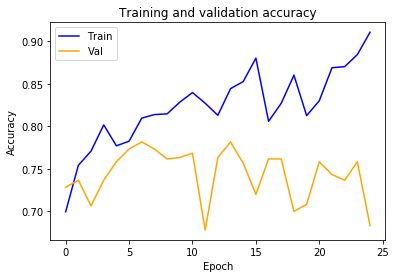

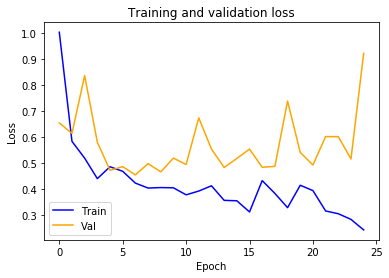

In [0]:
plot(model1_history)

It looks like there is some overfitting after the 7th epoch so I retrained and stopped at epoch 7 and showed that plot below.

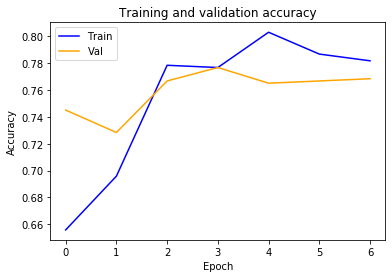

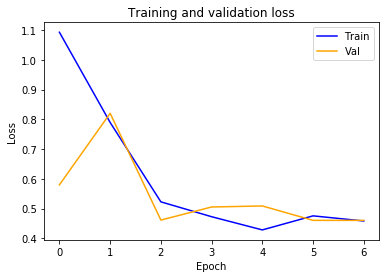

In [0]:
plot(model1_history)

Now lets evaluate the model on the test data we have.  A simple way us to just evaluate on all the test patches.  Since I broke out the test directory into each class, we can just use the evaluate method.

In [16]:
#lets just check the first batch in our test data since there are 32 imgs
test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True,
        class_mode="binary")

Found 2184 images belonging to 2 classes.


In [0]:
test_m1 = model1.evaluate_generator(test_gen)

  ...
    to  
  ['...']


In [0]:
print(model1.metrics_names)
print(test_m1)

['loss', 'accuracy']
[0.5732661658439083, 0.73672163]


So it looks like the basic dense DNN model does not work that well if you review the test evaluation metrics above.  So lets keep going.

In [0]:
model1.save('/content/model1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/model1/assets


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Save model1 to google drive as zip

In [0]:
#zip
if not os.path.exists('/content/gdrive/My Drive/model1.zip'):
  model1_archive = shutil.make_archive('/content/gdrive/My Drive/model1', 'zip', '/content/model1')
  print(model1_archive)
  print(os.path.getsize(model1_archive)/1048576,"mb")
else:
  print('Zip archive exists')

/content/gdrive/My Drive/model1.zip
33.37103271484375 mb


### Initial CNN Model

In [0]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3), padding="same"))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)            

In [0]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2_history = model2.fit_generator(
        train_gen,
        epochs=8,
        shuffle=True,
        validation_data=validation_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 75 steps, validate for 19 steps
Epoch 1/8
75/75 [==============================] - 2s 31ms/step - loss: 0.5143 - accuracy: 0.7458 - val_loss: 0.4658 - val_accuracy: 0.7950
Epoch 2/8
75/75 [==============================] - 2s 25ms/step - loss: 0.4105 - accuracy: 0.8183 - val_loss: 0.3976 - val_accuracy: 0.8267
Epoch 3/8
75/75 [==============================] - 2s 25ms/step - loss: 0.4161 - accuracy: 0.8225 - val_loss: 0.4446 - val_accuracy: 0.7817
Epoch 4/8
75/75 [==============================] - 2s 25ms/step - loss: 0.3652 - accuracy: 0.8321 - val_loss: 0.4233 - val_accuracy: 0.7917
Epoch 5/8
75/75 [==============================] - 2s 25ms/step - loss: 0.3466 - accuracy: 0.8504 - val_loss: 0.3951 - val_accuracy: 0.8300
Epoch 6/8
75/75 [==============================] - 2s 25ms/step - loss: 0.3109 - accuracy: 0.8600 - val_loss: 0.3547 - val_accuracy: 0.8283
Epoch 7/8
75/75 [==============================] - 2s 25ms/step - lo

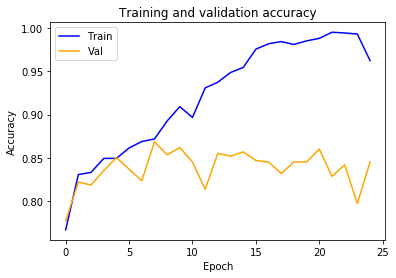

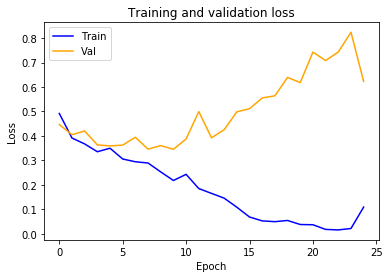

In [0]:
plot(model2_history)

Overfitting is definitelly occuring past the 8th epoch so I rerun the train for only 8 epochs.

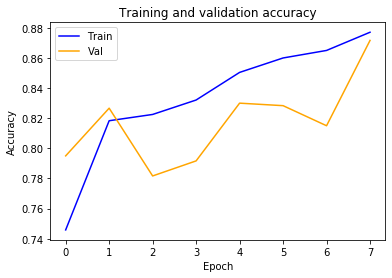

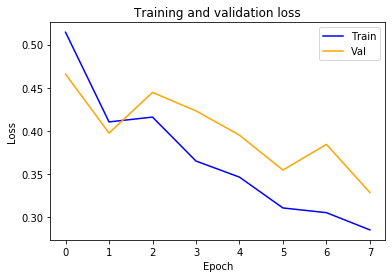

In [0]:
plot(model2_history)

In [0]:
test_m2 = model2.evaluate_generator(test_gen)
print(model2.metrics_names)
print(test_m2)

  ...
    to  
  ['...']
['loss', 'accuracy']
[0.3637118289868037, 0.8269231]


Comparing the initial CNN model with the basic DNN model, we can see an increase in performance while looking at the test loss and accuracy numbers.

In [0]:
model2.save('/content/model2')

INFO:tensorflow:Assets written to: /content/model2/assets


In [0]:
#zip and save to google drive
if not os.path.exists('/content/gdrive/My Drive/model2.zip'):
  model2_archive = shutil.make_archive('/content/gdrive/My Drive/model2', 'zip', '/content/model2')
  print(model2_archive)
  print(os.path.getsize(model2_archive)/1048576,"mb")
else:
  print('Zip archive exists')

/content/gdrive/My Drive/model2.zip
11.265266418457031 mb


#### Does data augmentation help?
Let's try some basic data augmentation.  Obviously we can't alter a lot of the image because its very specific, but some rotations and zoom seem acceptable.

In [0]:
train_datagen_augment = ImageDataGenerator(rescale=1./255, 
                                           zoom_range=0.2, 
                                           rotation_range=180)

train_gen_aug = train_datagen_augment.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True,
        class_mode="binary")

Found 2400 images belonging to 2 classes.


In [0]:
model2a = model2
model2a_history = model2a.fit_generator(
        train_gen_aug,
        epochs=8,
        shuffle=True,
        validation_data=validation_gen)

Epoch 1/8
75/75 [==============================] - 11s 151ms/step - loss: 0.3760 - accuracy: 0.8246 - val_loss: 0.6732 - val_accuracy: 0.7050
Epoch 2/8
75/75 [==============================] - 11s 149ms/step - loss: 0.3573 - accuracy: 0.8367 - val_loss: 0.6964 - val_accuracy: 0.6467
Epoch 3/8
75/75 [==============================] - 11s 147ms/step - loss: 0.3590 - accuracy: 0.8388 - val_loss: 0.5500 - val_accuracy: 0.6983
Epoch 4/8
75/75 [==============================] - 11s 146ms/step - loss: 0.3679 - accuracy: 0.8379 - val_loss: 1.0529 - val_accuracy: 0.6383
Epoch 5/8
75/75 [==============================] - 11s 146ms/step - loss: 0.3341 - accuracy: 0.8479 - val_loss: 0.5911 - val_accuracy: 0.7433
Epoch 6/8
75/75 [==============================] - 11s 146ms/step - loss: 0.3290 - accuracy: 0.8500 - val_loss: 0.5468 - val_accuracy: 0.7500
Epoch 7/8
75/75 [==============================] - 11s 144ms/step - loss: 0.3361 - accuracy: 0.8479 - val_loss: 0.7068 - val_accuracy: 0.6833
Epoch 

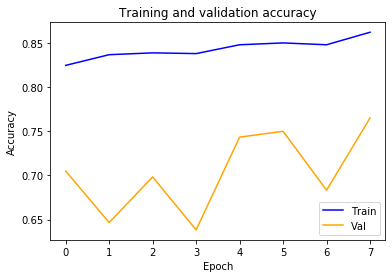

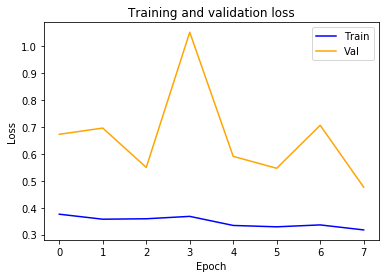

In [0]:
plot(model2a_history)

In [0]:
test_m2a = model2a.evaluate_generator(test_gen)
print(model2a.metrics_names)
print(test_m2a)

['loss', 'accuracy']
[0.3298350384701853, 0.8305861]


It doesn't look like data augmentation is helping, most likely due to the limits of how much we can augment.

### InceptionV3 Model
This time I use checkpoints while training since this takes a lot more time and is not fun to rerun.

In [0]:
ckpt_folder = "/content/model3-e001.ckpt/"
if os.path.exists(ckpt_folder):
  !rm -rf $ckpt_folder

In [0]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='avg')

top_model = models.Sequential()
top_model.add(layers.Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(layers.Dense(64, activation='relu'))
top_model.add(layers.Dense(1, activation='sigmoid'))

model3 = tf.keras.Model(base_model.input,top_model(base_model.output))

model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 63, 63, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 63, 63, 32)   96          conv2d_194[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 63, 63, 32)   0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [0]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=11, verbose=0, mode='min')
cp_save = tf.keras.callbacks.ModelCheckpoint('/content/model3-e{epoch:03d}.ckpt', save_best_only=True, monitor='val_loss', mode='min')

model3_history = model3.fit_generator(
        train_gen, 
        epochs=35, 
        shuffle=True, 
        callbacks=[earlyStopping,cp_save], 
        validation_data=validation_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 75 steps, validate for 19 steps
Epoch 1/35
75/75 [==============================] - 46s 607ms/step - loss: 0.5387 - accuracy: 0.7887 - val_loss: 7.3384 - val_accuracy: 0.6067
Epoch 2/35
75/75 [==============================] - 38s 505ms/step - loss: 0.4318 - accuracy: 0.8163 - val_loss: 2.6120 - val_accuracy: 0.6067
Epoch 3/35
75/75 [==============================] - 38s 508ms/step - loss: 0.4133 - accuracy: 0.7950 - val_loss: 1.0210 - val_accuracy: 0.6067
Epoch 4/35
75/75 [==============================] - 38s 505ms/step - loss: 0.3745 - accuracy: 0.8233 - val_loss: 0.7575 - val_accuracy: 0.5917
Epoch 5/35
75/75 [==============================] - 6s 84ms/step - loss: 0.3705 - accuracy: 0.8292 - val_loss: 0.9637 - val_accuracy: 0.6633
Epoch 6/35
75/75 [==============================] - 6s 83ms/step - loss: 0.3451 - accuracy: 0.8467 - val_loss: 0.8533 - val_accuracy: 0.7350
Epoch 7/35
75/75 [==============================] - 6s

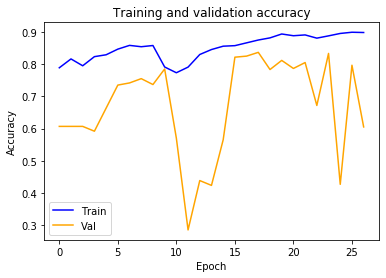

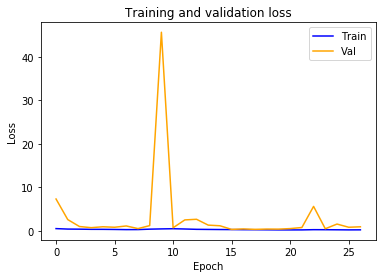

In [0]:
plot(model3_history)

It looks like overfitting did start occuring around epoch 20, but since I saved checkpoints, I do have the epochs saved and can load a previous run best epoch.

In [18]:
#extract epoch from 
if not os.path.exists('/content/model3-e018.ckpt'):
  model_dir='/content/model3-e018.ckpt'
  #unzip
  !unzip -q '/content/gdrive/My Drive/model3-e018.zip' -d $model_dir
  print(model_dir)

/content/model3-e018.ckpt


In [0]:
model3a = models.load_model('/content/model3-e018.ckpt')

Simple evaluation

In [20]:
test_m3 = model3a.evaluate_generator(test_gen)
print(model3a.metrics_names)
print(test_m3)

['loss', 'accuracy']
[0.24025140551553256, 0.92948717]


This looks like my best model based on the test loss and accuracy scores.  So I will use this one on my further test results and evaluation.

In [21]:
#zip the model
if not os.path.exists('/content/model3-e018.zip'):
  model_archive = shutil.make_archive('/content/gdrive/My Drive/model3-e018', 'zip', '/content/model3-e018.ckpt/')
  print(model_archive)
  print(os.path.getsize(model_archive)/1048576,"mb")
else:
  print('Model zip archive exists')

/content/gdrive/My Drive/model3-e018.zip
230.89807224273682 mb


## Evaluation
Since we chose 3 test slides, lets see what the predicted heatmaps look like for each.

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from skimage.color import rgb2gray
import math
import random
import shutil
import csv
import pandas as pd
from collections import defaultdict
from os.path import abspath, join, basename, exists
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from openslide import open_slide, __library_version__ as openslide_version
from tensorflow.keras.preprocessing import image

# Starter code to download small files
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(128, 128))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [39]:
#load data
lvl4_data_url = "http://muftayebaly.com/dropbox/sample_patches_lvl4.zip"
sample_file = "/content/sample_patches_lvl4.zip"
sample_folder= "/content/slides_sample/"
if not os.path.exists(sample_folder):
  os.makedirs(sample_folder)
sample_path = download_if_missing(lvl4_data_url,
                    sample_file,
                    extract=False)
print(sample_path)

#unzip
!unzip -q $sample_path -d $sample_folder
print(sample_folder)

/content/sample_patches_lvl4.zip
/content/slides_sample/


In [0]:
#get the csv data
csv_url = sample_folder + 'sample_data.csv'
sample_data =[]

with open(csv_url) as myfile:
    reader = csv.DictReader(myfile, fieldnames=["slideId", "patch_path", "level", "size", "patch_x", "patch_y", "cancer", "type"])
    next(reader)
    for row in reader:
        sample_data.append(row)
        row=[]
sample_df = pd.DataFrame(sample_data)

In [42]:
#chosen test slides
test_choice=['002','075','101']

#get test dataset details
test_data = sample_df[sample_df.type=='test']
print(test_data)

     slideId                                         patch_path  ... cancer  type
0        002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
1        002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
2        002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
3        002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
4        002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
...      ...                                                ...  ...    ...   ...
2179     101  /content/slides_sample/test/no_cancer/101_lvl_...  ...      0  test
2180     101  /content/slides_sample/test/no_cancer/101_lvl_...  ...      0  test
2181     101  /content/slides_sample/test/no_cancer/101_lvl_...  ...      0  test
2182     101  /content/slides_sample/test/no_cancer/101_lvl_...  ...      0  test
2183     101  /content/slides_sample/test/no_cancer/101_lvl_...  ...      0  test

[2184 rows x 8 

Re-mount my drive to get the initial slides

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = '/content/gdrive/My Drive/'
slide_dir = '/content/gdrive/My Drive/slides/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Heatmaps
Now let's look at a test tumor_101.tif

#### tumor_101.tif

In [0]:
slide101 = open_slide(slide_dir+'tumor_101.tif')
mask101 = open_slide(slide_dir+'tumor_101_mask.tif')

slide101_image = read_slide(slide101, 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=slide101.level_dimensions[4][0], 
                         height=slide101.level_dimensions[4][1])
mask101_image = read_slide(mask101, 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=mask101.level_dimensions[4][0], 
                         height=mask101.level_dimensions[4][1])[:,:,0]

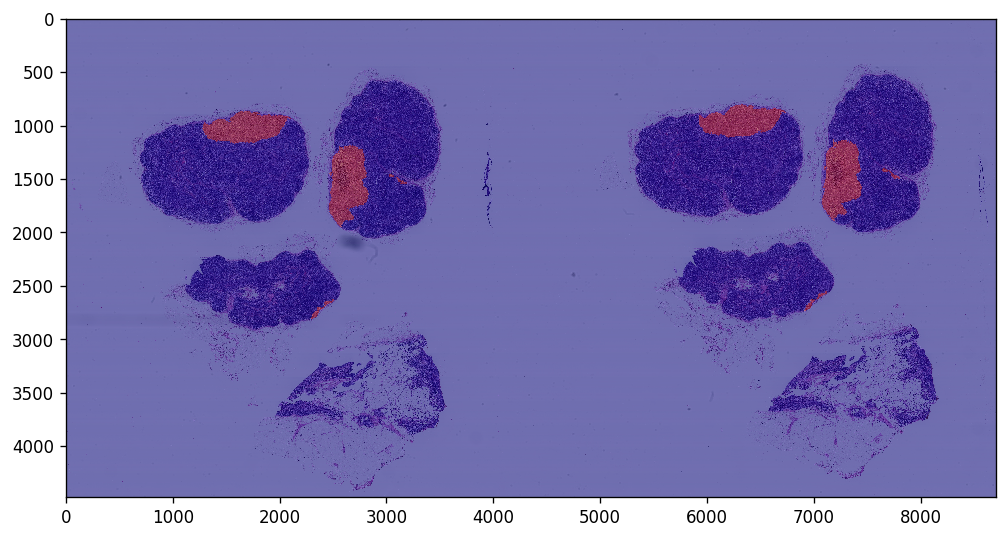

In [0]:
plt.figure(figsize=(10,10), dpi=120)
plt.imshow(slide101_image)
plt.imshow(mask101_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
plt.imsave('/content/test101.jpg',slide101_image)

Now lets start making our prediction heatmap and compare to the above.

In [0]:
#load my best model
#extract model to colab
!unzip -q '/content/gdrive/My Drive/model3-e018.zip' -d '/content/bestModel/'

model = models.load_model('/content/bestModel/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Create base image for adding the heatmap to

In [0]:
img = Image.open(r'/content/test101.jpg')

In [0]:
heatmap101 = Image.new('RGB',(slide101.level_dimensions[4][0],slide101.level_dimensions[4][1]))
heatmap101.paste(img)

In [0]:
#images to use for the heatmap creation
heat1 = Image.new('RGB',(128,128),(213, 135, 0))
heat2 = Image.new('RGB',(128,128),(213, 85, 0))
heat3 = Image.new('RGB',(128,128),(213, 15, 0))

In [0]:
#test data for this slide
test1_patches = test_data[test_data.slideId=='101']
size=128

In [0]:
print(test1_patches[test1_patches.cancer=='1'])

     slideId                                         patch_path  ... cancer  type
1354     101  /content/slides_sample/test/cancer/101_lvl_4_x...  ...      1  test
1355     101  /content/slides_sample/test/cancer/101_lvl_4_x...  ...      1  test
1356     101  /content/slides_sample/test/cancer/101_lvl_4_x...  ...      1  test
1370     101  /content/slides_sample/test/cancer/101_lvl_4_x...  ...      1  test
1371     101  /content/slides_sample/test/cancer/101_lvl_4_x...  ...      1  test
...      ...                                                ...  ...    ...   ...
1886     101  /content/slides_sample/test/cancer/101_lvl_4_x...  ...      1  test
1887     101  /content/slides_sample/test/cancer/101_lvl_4_x...  ...      1  test
1899     101  /content/slides_sample/test/cancer/101_lvl_4_x...  ...      1  test
1900     101  /content/slides_sample/test/cancer/101_lvl_4_x...  ...      1  test
1912     101  /content/slides_sample/test/cancer/101_lvl_4_x...  ...      1  test

[102 rows x 8 c

Loop through all test patches for the slide, predict cancer, and add appropriate image to the heatmap. Remember, 0=cancer and 1=no cancer from our classes in the model.

In [0]:
predicted_data=[]
for row in test1_patches.iterrows():
  prediction={}
  #print(row[1]['slideId'])
  loadImg = load_image(row[1]['patch_path'])
  pred = model.predict(loadImg)
  prediction['pred']=pred[0][0]
  prediction['location_x']=int(row[1]['patch_x'])*size
  prediction['location_y']=int(row[1]['patch_y'])*size
  prediction['actual']=1-int(row[1]['cancer']) #since the class and my data are flipped
  predicted_data.append(prediction)
print('Done')

Done


In [0]:
#for row in predicted_data:
#  if row['actual']==0:
#    print(row)

Paste to my heatmap

In [0]:
for pred in predicted_data:
  if pred['pred']<=0.5 and pred['pred']>0.34:
    heatmap101.paste(heat1, (pred['location_x'],pred['location_y']))
  elif pred['pred']<=0.34 and pred['pred']>0.18:
    heatmap101.paste(heat2, (pred['location_x'],pred['location_y']))
  elif pred['pred']<=0.18:
    heatmap101.paste(heat3, (pred['location_x'],pred['location_y']))

Save heatmap for later use.

In [0]:
heatmap101.save('/content/heatmap101.jpg')

Show heatmap

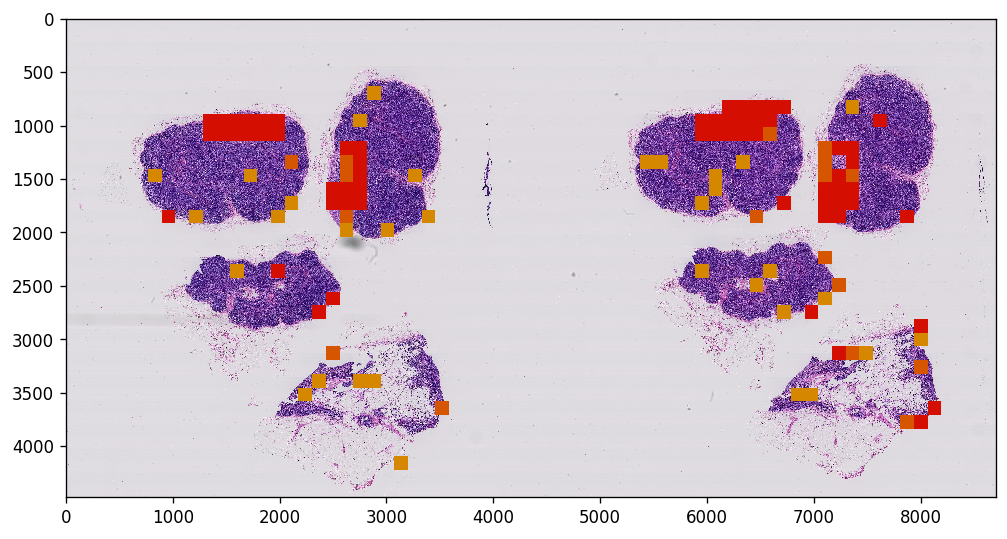

In [0]:
plt.figure(figsize=(10,10), dpi=120)
img101=mpimg.imread('/content/heatmap101.jpg')
plt.imshow(img101)
plt.show()

Not a bad prediction for a level 4 model.  This would really help a pathologist determine areas to focus for cancer.

Now lets do the same thing for another test.
#### tumor_002.tif

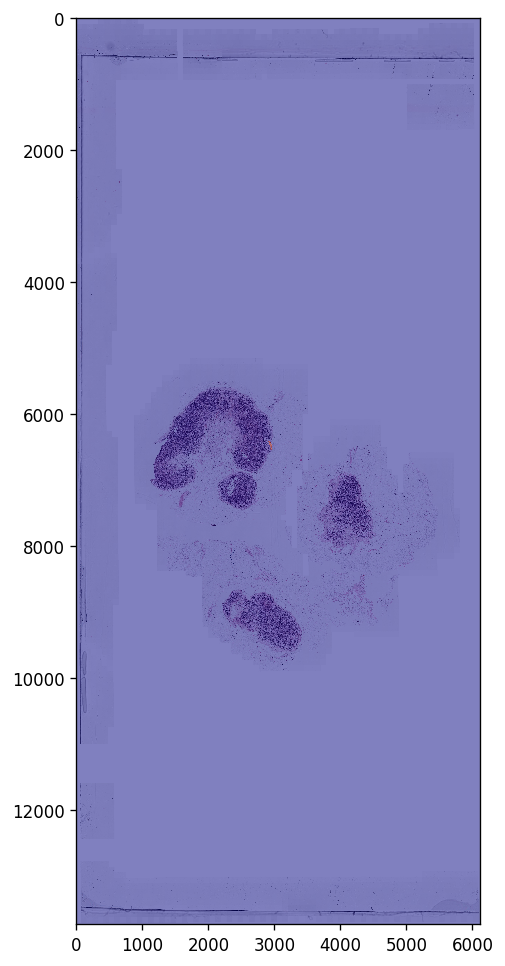

In [0]:
slide002 = open_slide(slide_dir+'tumor_002.tif')
mask002 = open_slide(slide_dir+'tumor_002_mask.tif')

slide002_image = read_slide(slide002, 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=slide002.level_dimensions[4][0], 
                         height=slide002.level_dimensions[4][1])
mask002_image = read_slide(mask002, 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=mask002.level_dimensions[4][0], 
                         height=mask002.level_dimensions[4][1])[:,:,0]

plt.figure(figsize=(10,10), dpi=120)
plt.imshow(slide002_image)
plt.imshow(mask002_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

plt.imsave('/content/test002.jpg',slide002_image)

Hmmmm, this may have not been the best test to pick, but it was randomly chosen so lets just go with it.

In [0]:
img = Image.open(r'/content/test002.jpg')
heatmap002 = Image.new('RGB',(slide002.level_dimensions[4][0],slide002.level_dimensions[4][1]))
heatmap002.paste(img)
#images to use for the heatmap creation
heat1 = Image.new('RGB',(128,128),(213, 135, 0))
heat2 = Image.new('RGB',(128,128),(213, 85, 0))
heat3 = Image.new('RGB',(128,128),(213, 15, 0))

In [0]:
#test data for this slide
test2_patches = test_data[test_data.slideId=='002']
size=128

In [0]:
print(test2_patches[test2_patches.cancer=='1'])

    slideId                                         patch_path  ... cancer  type
194     002  /content/slides_sample/test/cancer/002_lvl_4_x...  ...      1  test
195     002  /content/slides_sample/test/cancer/002_lvl_4_x...  ...      1  test

[2 rows x 8 columns]


In [0]:
predicted_data2=[]
for row in test2_patches.iterrows():
  prediction={}
  #print(row[1]['slideId'])
  loadImg = load_image(row[1]['patch_path'])
  pred = model.predict(loadImg)
  prediction['pred']=pred[0][0]
  prediction['location_x']=int(row[1]['patch_x'])*size
  prediction['location_y']=int(row[1]['patch_y'])*size
  prediction['actual']=1-int(row[1]['cancer']) #since the class and my data are flipped
  predicted_data2.append(prediction)
print('Done')

Done


In [0]:
#did we predict any patch as cancer?
for row in predicted_data2:
  if row['actual']==0:
    print(row)

{'pred': 0.7064411, 'location_x': 2816, 'location_y': 6400, 'actual': 0}
{'pred': 0.98837155, 'location_x': 2944, 'location_y': 6400, 'actual': 0}


Well it looks like the patches that did have some cancer were not predicted as cancerous unfortunately.  But lets loop through the whole prediction and see if anything was found.

In [0]:
for pred in predicted_data2:
  if pred['pred']<=0.5 and pred['pred']>0.34:
    heatmap002.paste(heat1, (pred['location_x'],pred['location_y']))
  elif pred['pred']<=0.34 and pred['pred']>0.18:
    heatmap002.paste(heat2, (pred['location_x'],pred['location_y']))
  elif pred['pred']<=0.18:
    heatmap002.paste(heat3, (pred['location_x'],pred['location_y']))

In [0]:
heatmap002.save('/content/heatmap002.jpg')

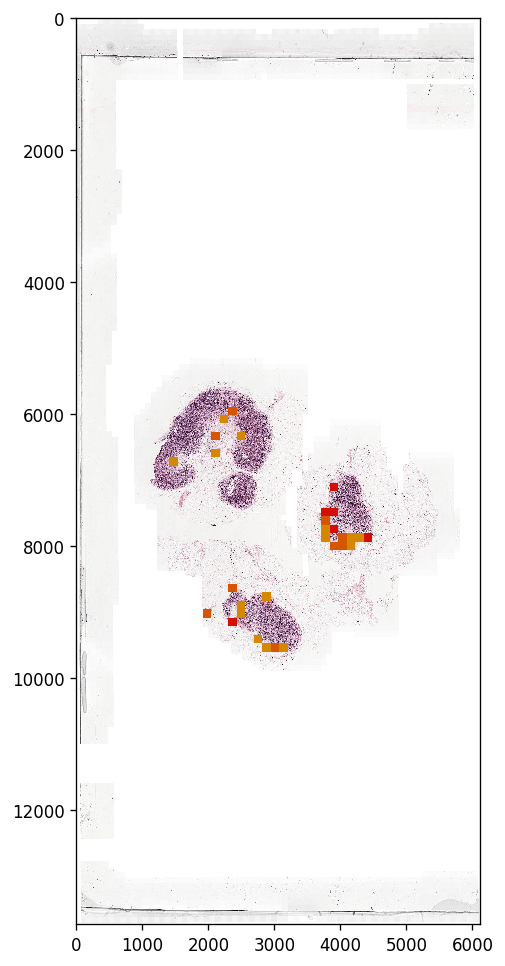

In [0]:
plt.figure(figsize=(10,10), dpi=120)
img002=mpimg.imread('/content/heatmap002.jpg')
plt.imshow(img002)
plt.show()

So it looks like there was some false predictions.  Not the best test case though.

Lets try the last test
#### tumor_075.tif

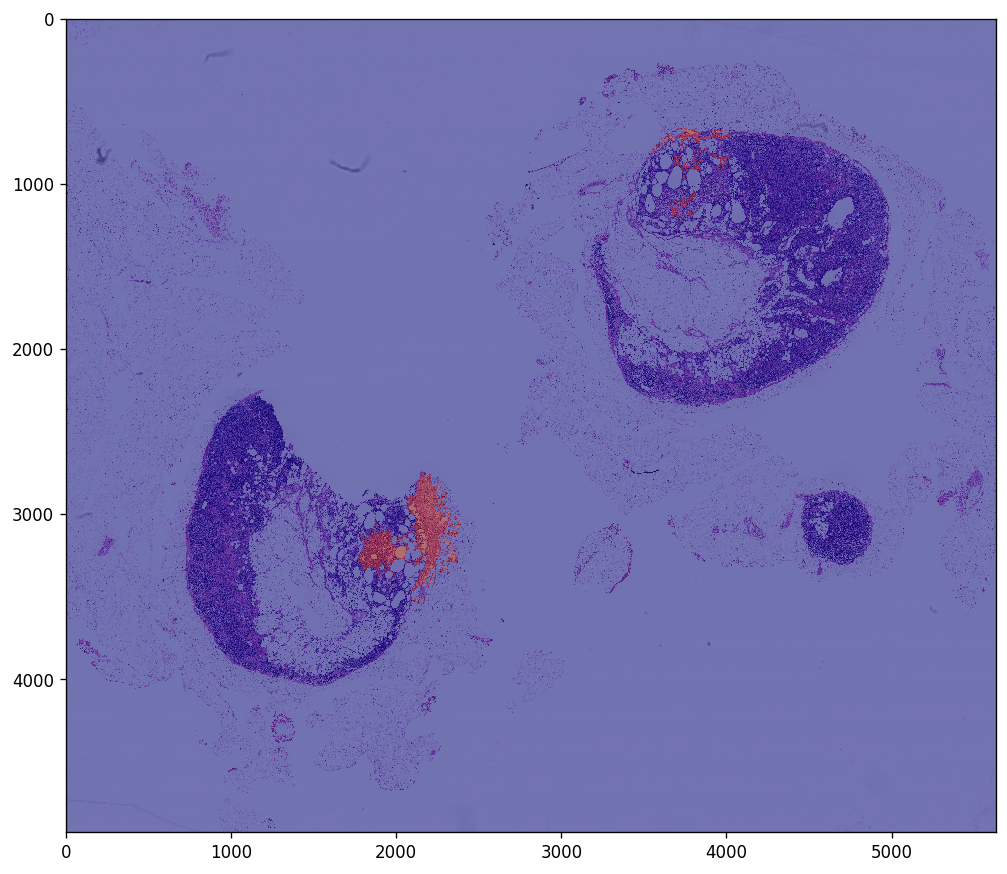

In [0]:
slide075 = open_slide(slide_dir+'tumor_075.tif')
mask075 = open_slide(slide_dir+'tumor_075_mask.tif')

slide075_image = read_slide(slide075, 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=slide075.level_dimensions[4][0], 
                         height=slide075.level_dimensions[4][1])
mask075_image = read_slide(mask075, 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=mask075.level_dimensions[4][0], 
                         height=mask075.level_dimensions[4][1])[:,:,0]

plt.figure(figsize=(10,10), dpi=120)
plt.imshow(slide075_image)
plt.imshow(mask075_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

plt.imsave('/content/test075.jpg',slide075_image)

In [0]:
img = Image.open(r'/content/test075.jpg')
heatmap075 = Image.new('RGB',(slide075.level_dimensions[4][0],slide075.level_dimensions[4][1]))
heatmap075.paste(img)

#test data for this slide
test3_patches = test_data[test_data.slideId=='075']
size=128

print(test3_patches[test3_patches.cancer=='1'])

     slideId                                         patch_path  ... cancer  type
602      075  /content/slides_sample/test/cancer/075_lvl_4_x...  ...      1  test
603      075  /content/slides_sample/test/cancer/075_lvl_4_x...  ...      1  test
604      075  /content/slides_sample/test/cancer/075_lvl_4_x...  ...      1  test
605      075  /content/slides_sample/test/cancer/075_lvl_4_x...  ...      1  test
621      075  /content/slides_sample/test/cancer/075_lvl_4_x...  ...      1  test
622      075  /content/slides_sample/test/cancer/075_lvl_4_x...  ...      1  test
623      075  /content/slides_sample/test/cancer/075_lvl_4_x...  ...      1  test
624      075  /content/slides_sample/test/cancer/075_lvl_4_x...  ...      1  test
625      075  /content/slides_sample/test/cancer/075_lvl_4_x...  ...      1  test
649      075  /content/slides_sample/test/cancer/075_lvl_4_x...  ...      1  test
650      075  /content/slides_sample/test/cancer/075_lvl_4_x...  ...      1  test
651      075  /c

In [0]:
predicted_data3=[]
for row in test3_patches.iterrows():
  prediction={}
  #print(row[1]['slideId'])
  loadImg = load_image(row[1]['patch_path'])
  pred = model.predict(loadImg)
  prediction['pred']=pred[0][0]
  prediction['location_x']=int(row[1]['patch_x'])*size
  prediction['location_y']=int(row[1]['patch_y'])*size
  prediction['actual']=1-int(row[1]['cancer']) #since the class and my data are flipped
  predicted_data3.append(prediction)
print('Done')

Done


In [0]:
#did we predict any patch as cancer?
#for row in predicted_data3:
#  if row['actual']==0:
#    print(row)

In [0]:
for pred in predicted_data3:
  if pred['pred']<=0.5 and pred['pred']>0.34:
    heatmap075.paste(heat1, (pred['location_x'],pred['location_y']))
  elif pred['pred']<=0.34 and pred['pred']>0.18:
    heatmap075.paste(heat2, (pred['location_x'],pred['location_y']))
  elif pred['pred']<=0.18:
    heatmap075.paste(heat3, (pred['location_x'],pred['location_y']))

In [0]:
#save for later
heatmap075.save('/content/heatmap075.jpg')

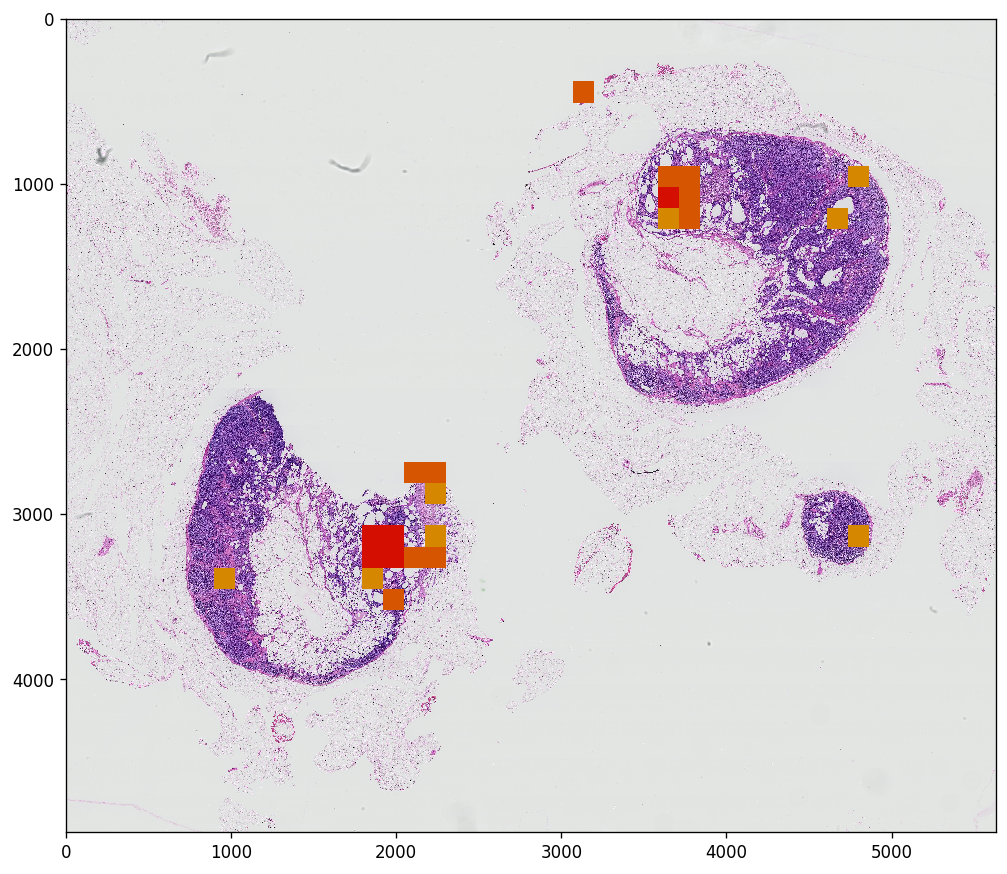

In [0]:
plt.figure(figsize=(10,10), dpi=120)
img075=mpimg.imread('/content/heatmap075.jpg')
plt.imshow(img075)
plt.show()

This predicted well.  The two actual major areas are showing up as potential areas in my prediction.

### Accuracy and Loss

I used a simple evaluate function for each of the 3 models since we know the truth.  Below is a comparison of the 3 models.  

| Model | Test Loss | Test Accuracy |
| --------- |---------:| -----:|
| Model1 - Basic DNN |    0.573266 |    0.736721 |
| Model2 - Initial CNN |    0.363711 |    0.826923 |
| Model3 - InceptionV3 |    0.240251 |    0.929487 |

Now lets try checking the AUC score as another method.

In [29]:
# load models
#extract epoch from 
if not os.path.exists('/content/model1'):
  model1_dir='/content/model1'
  #unzip
  !unzip -q '/content/gdrive/My Drive/model1.zip' -d $model1_dir
  print(model1_dir)
else:
  print('Model 1 exists')

if not os.path.exists('/content/model2'):
  model2_dir='/content/model2'
  #unzip
  !unzip -q '/content/gdrive/My Drive/model2.zip' -d $model2_dir
  print(model2_dir)
else:
  print('Model 2 exists')

if not os.path.exists('/content/model3-e018.ckpt'):
  model3_dir='/content/model3-e018.ckpt'
  #unzip
  !unzip -q '/content/gdrive/My Drive/model3-e018.zip' -d $model3_dir
  print(model3_dir)
else:
  print('Model 3 exists')

Model 1 exists
Model 2 exists
/content/model3-e018.ckpt


In [0]:
model1 = models.load_model('/content/model1')
model2 = models.load_model('/content/model2')
model3 = models.load_model('/content/model3-e018.ckpt')

Get prediction and true values for each model

In [43]:
print(test_data)

     slideId                                         patch_path  ... cancer  type
0        002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
1        002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
2        002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
3        002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
4        002  /content/slides_sample/test/no_cancer/002_lvl_...  ...      0  test
...      ...                                                ...  ...    ...   ...
2179     101  /content/slides_sample/test/no_cancer/101_lvl_...  ...      0  test
2180     101  /content/slides_sample/test/no_cancer/101_lvl_...  ...      0  test
2181     101  /content/slides_sample/test/no_cancer/101_lvl_...  ...      0  test
2182     101  /content/slides_sample/test/no_cancer/101_lvl_...  ...      0  test
2183     101  /content/slides_sample/test/no_cancer/101_lvl_...  ...      0  test

[2184 rows x 8 

In [45]:
pred1=[] #array of true and prediction
for row in test_data.iterrows():
  loadImg = load_image(row[1]['patch_path'])
  pred = model1.predict(loadImg)
  pred1.append([pred[0][0],1-int(row[1]['cancer'])])
print('Done model 1')

pred2=[] #array of true and prediction
for row in test_data.iterrows():
  loadImg = load_image(row[1]['patch_path'])
  pred = model2.predict(loadImg)
  pred2.append([pred[0][0],1-int(row[1]['cancer'])])
print('Done model 2')

pred3=[] #array of true and prediction
for row in test_data.iterrows():
  loadImg = load_image(row[1]['patch_path'])
  pred = model3.predict(loadImg)
  pred3.append([pred[0][0],1-int(row[1]['cancer'])])
print('Done model 3')

Done model 1
Done model 2
Done model 3


In [52]:
y1_true = [i[1] for i in pred1]
y1_pred = [i[0] for i in pred1]
AUC1 = tf.keras.metrics.AUC(num_thresholds=50)
AUC1.update_state(y1_true, y1_pred)

print('Model1 AUC:', AUC1.result().numpy())

Model1 AUC: 0.79670316


In [53]:
y2_true = [i[1] for i in pred2]
y2_pred = [i[0] for i in pred2]
AUC2 = tf.keras.metrics.AUC(num_thresholds=50)
AUC2.update_state(y2_true, y2_pred)

print('Model2 AUC:', AUC2.result().numpy())

Model2 AUC: 0.8690635


In [57]:
y3_true = [i[1] for i in pred3]
y3_pred = [i[0] for i in pred3]
AUC3 = tf.keras.metrics.AUC(num_thresholds=50)
AUC3.update_state(y3_true, y3_pred)

print('Model3 AUC:', AUC3.result().numpy())

Model3 AUC: 0.8400275


Using AUC, it looks like model 2 has the best score.

The full evaluation table:

| Model | Test Loss | Test Accuracy | AUC |
| --------- |---------:| -----:| ---:|
| Model1 - Basic DNN |    0.573266 |    0.736721 |  0.796703 |
| Model2 - Initial CNN |    0.363711 |    0.826923 | 0.869063 |
| Model3 - InceptionV3 |    0.240251 |    0.929487 | 0.840027 |

## How to improve the model?
Based on what I have seen, I think the best way to improve the model is to use more zoom levels in the dataset.  If I were to use a more zoomed in level for my 128x128 patches, I am sure the accuracy would improve.  This would even result in more patches and would give us a bigger balanced data since we would have more cancer patches to work with.


Another way to improve the model is to try other training methods for the unbalanced dataset.  I randomly chose certain non-cancer patches to work with since the dataset was so unbalanced and there are ways to work around that.